# Predicting Number of Orders (Regression)
created by: Ari Sulistiyo Prabowo

List of contents:
- Data Preparation
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Modelling
___

In [ ]:
# import library
import pandas as pd
import numpy as np

# pre-processing & model
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

### Data Preparation

In [ ]:
#reading the data
data = pd.read_csv("/Users/ari/Documents/Data Ari/Data Science/Project/Number of Orders Prediction/supplement_data.csv")
display(data.shape)
display(data.info())
display(data.describe())
data.head()

(188340, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


None

,Store_id,Holiday,#Order,Sales
count,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,0.131783,68.205692,42784.327982
std,105.366308,0.338256,30.467415,18456.708302
min,1.000000,0.000000,0.000000,0.000000
25%,92.000000,0.000000,48.000000,30426.000000
50%,183.000000,0.000000,63.000000,39678.000000
75%,274.000000,0.000000,82.000000,51909.000000
max,365.000000,1.000000,371.000000,247215.000000


,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [ ]:
# check any null values

def check_data_quality(input_data):
  """
  Data quality is on the most importent before applying any missing learning model
  Some of ML models are very sensitive towards the missing value, duplicated data and others
  input_data: variable that you save to read the data
  """
  #Shows the result in the percentage of data duplication
  duplication = input_data.duplicated().sum()/input_data.shape[0]*100
  print("There are around {:.2f}% of data duplication \n".format(duplication))

  #Shows the result in the percentage of null value
  type_null = pd.DataFrame(input_data.dtypes).T.rename(index = {0: 'Columns Type'})
  type_null = type_null.append(pd.DataFrame(input_data.isnull().sum()).T.rename(index = {0: 'Amount of Null Values'}))
  type_null = type_null.append(pd.DataFrame(input_data.isnull().sum()/input_data.shape[0]*100).T.rename(index = {0: 'Percentage of Null Values'}))
  
  return(type_null.T)

In [ ]:
check_data_quality(data)

There are around 0.00% of data duplication 



,Columns Type,Amount of Null Values,Percentage of Null Values
ID,object,0,0.0
Store_id,int64,0,0.0
Store_Type,object,0,0.0
Location_Type,object,0,0.0
Region_Code,object,0,0.0
Date,object,0,0.0
Holiday,int64,0,0.0
Discount,object,0,0.0
#Order,int64,0,0.0
Sales,float64,0,0.0


### Exploratory Data Analysis

In [ ]:
# stores insight
unique_store = data['Store_id'].nunique()
print("There are {} unique stores in the dataset".format(unique_store))

There are 365 unique stores in the dataset


In [ ]:
# counting the categorical data
def countplot_cat(variable,p,l):
    """
    This function is used to visualize the categorical data that has more than four unique values
    variable: input your field/column
    """
    
    fig, ax = plt.subplots(1,1, figsize=(p,l))

    sns.countplot(data=data, x=variable)

    total = float(len(data))

    for p in ax.patches:
            percentage = '{:.2f}%'.format(100*p.get_height()/total)
            x = p.get_x() + p.get_width() / 2.5
            y = p.get_y() + p.get_height() / .98
            ax.annotate(percentage, (x,y))

    plt.show()

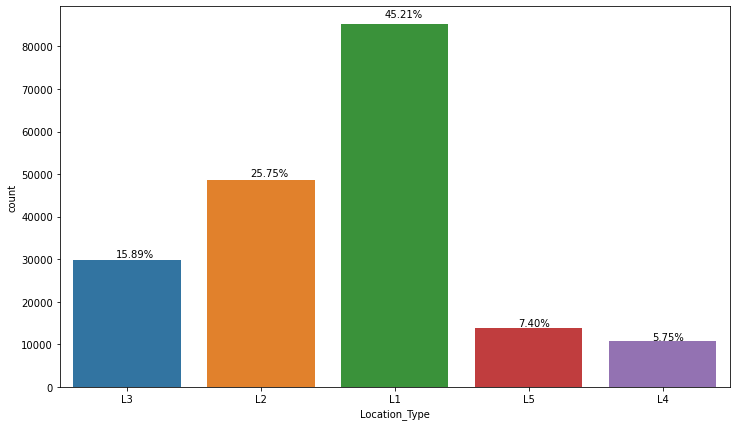

In [ ]:
countplot_cat(variable='Location_Type',p=12,l=7)

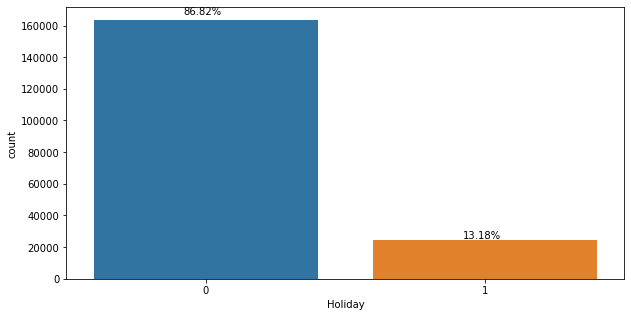

In [ ]:
countplot_cat(variable='Holiday',p=10,l=5)

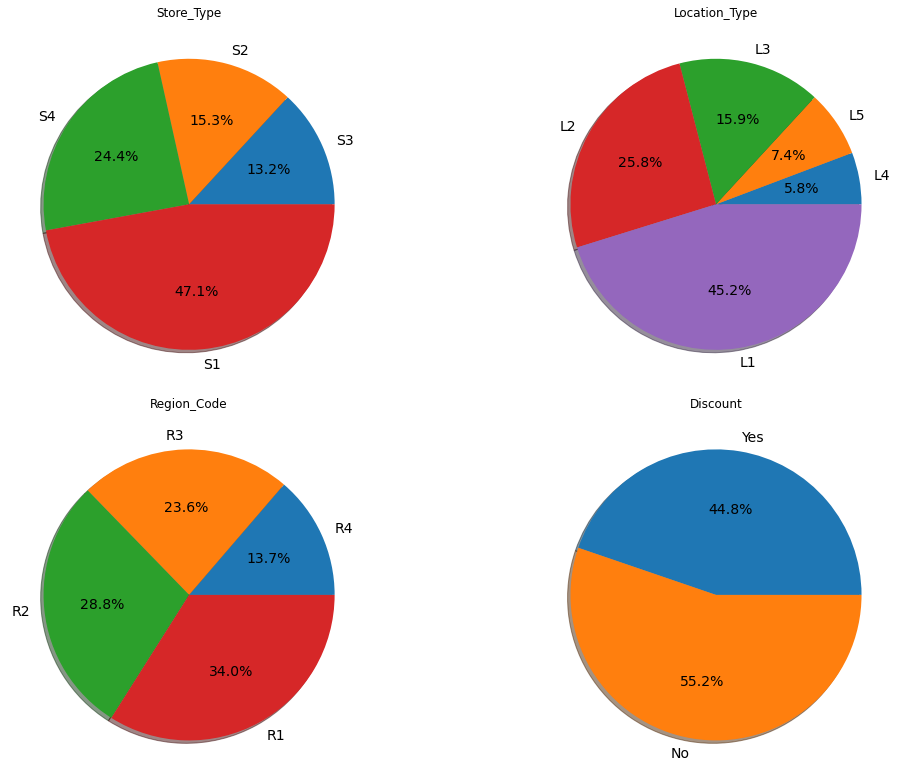

In [ ]:
# visualize the categorical data in pie chart
cat_cols = ['Store_Type','Location_Type','Region_Code','Discount']

fig, axes = plt.subplots(2,2, figsize=(17,11))
axes = [ax for axes_row in axes for ax in axes_row]

for i, col in enumerate(cat_cols):
  _ = data[col].value_counts()[::-1].plot(kind='pie',ax=axes[i], title=col, autopct='%1.1f%%', shadow=True, fontsize=14)
  _ = axes[i].set_ylabel('')

_ = plt.tight_layout()

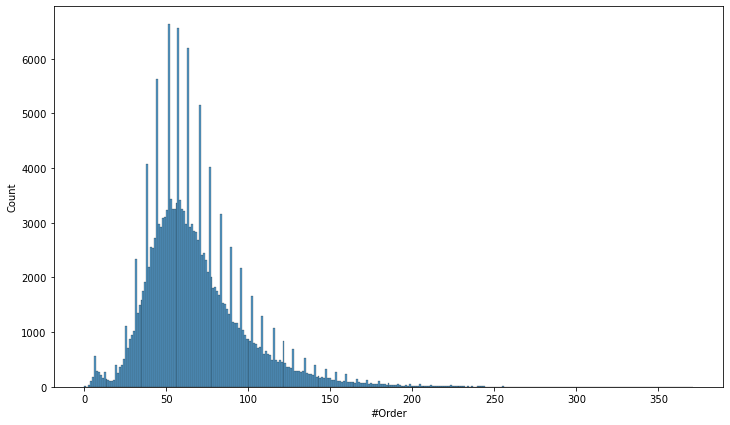

In [ ]:
# visualization target variable
plt.figure(figsize=(12,7))
sns.histplot(data=data, x='#Order')
plt.show()

### Data Preprocessing
This step, I do the preprocessing things to be able to put the data into the model. It contains:
- Feature Encoder
- Separate the dataset into training data (80%) and testing data (20%)

In [ ]:
cat_cols = ['Store_Type', 'Location_Type', 'Region_Code','Discount']

#create new variable so the original variable keep remaining
encod_data = data.copy()

#label encoder object
label_encod = LabelEncoder()

#encode the data
for i in cat_cols:
    encod_data[i] = label_encod.fit_transform(encod_data[i])

In [ ]:
#separate independent variable and target variable
X = encod_data.drop(['#Order','ID','Store_id','Date','Sales'], axis=1) #independent
y = encod_data['#Order'] #target

#separate training data (80%) and testing data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

### Modelling
In this stage, I use two different models (GradientBoostingClassifer & XGBoost)

In [ ]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print('For training data ---------')
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_train, y_pred_train)))
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_train, y_pred_train)))
print("R2 Score: {:.2f} \n".format(r2_score(y_train, y_pred_train)))

print('For testing data ---------')
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred_test)))
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_test)))
print("R2 Score: {:.2f}".format(r2_score(y_test, y_pred_test)))

For training data ---------
Mean Absolute Error: 16.18
Mean Squared Error: 497.89
R2 Score: 0.46 

For testing data ---------
Mean Absolute Error: 16.09
Mean Squared Error: 488.78
R2 Score: 0.47


In [ ]:
gb = GradientBoostingRegressor()

gb.fit(X_train, y_train)

y_pred_train_gb = gb.predict(X_train)
y_pred_test_gb = gb.predict(X_test)

print('For training data ---------')
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_train, y_pred_train_gb)))
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_train, y_pred_train_gb)))
print("R2 Score: {:.2f} \n".format(r2_score(y_train, y_pred_train_gb)))

print('For testing data ---------')
print("Mean Absolute Error: {:.2f}".format(mean_absolute_error(y_test, y_pred_test_gb)))
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_test_gb)))
print("R2 Score: {:.2f}".format(r2_score(y_test, y_pred_test_gb)))

For training data ---------
Mean Absolute Error: 13.09
Mean Squared Error: 361.47
R2 Score: 0.61 

For testing data ---------
Mean Absolute Error: 13.00
Mean Squared Error: 352.70
R2 Score: 0.62
